---------------

**If any part of this notebook is used in your research, please cite with the reference found in** **[README.md](https://github.com/pysal/spaghetti#bibtex-citation).**


----------------
## Caveats
### Demonstrating known caveats and tweaks in `spaghetti`

**Author: James D. Gaboardi** **<jgaboardi@gmail.com>**

**This notebook demonstrates the following limitations and caveats:**

1. Limitations in non-planarity
2. Relaxing vertex coordinate precision
3. Distance matrices and shortest paths between (dis)connected components
4. Understanding network generation

In [1]:
%config InlineBackend.figure_format = "retina"

In [2]:
%load_ext watermark
%watermark

Last updated: 2021-06-28T19:31:22.387312-04:00

Python implementation: CPython
Python version       : 3.9.4
IPython version      : 7.24.1

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 20.5.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit



In [3]:
import geopandas
import libpysal
from libpysal.cg import Point, Chain
import matplotlib
import matplotlib.pyplot as plt
import numpy
import shapely
import spaghetti

%matplotlib inline
%watermark -w
%watermark -iv

Watermark: 2.2.0

matplotlib: 3.4.2
libpysal  : 4.4.0
json      : 2.0.9
spaghetti : 1.6.2
geopandas : 0.9.0
numpy     : 1.20.3
shapely   : 1.7.1



##### Helper functions for arc and vertex labeling

In [4]:
def arc_labels(a, b, s, c="comp_label", offset=[-0.025, 0.025]):
    """Label each network arc."""
    def _lab_loc(_x):
        """Helper for labeling network arcs."""
        xy = _x.geometry.interpolate(0.5, normalized=True).coords[0]
        xy = tuple([_xy+o for (_xy,o) in zip(xy,offset)])
        return xy
    kws = {"ha":"right", "va":"bottom","weight":"bold","color":"k","size":s}
    a.apply(lambda x: b.annotate(text=x[c], xy=_lab_loc(x), **kws), axis=1)

def vert_labels(v, b, s, offset=[0.025, 0.025], col="comp_label", c="r"):
    """Label each network vertex."""
    def _lab_loc(_x):
        """Internal helper for labeling vertices."""
        xy = _x.geometry.coords[0]
        xy = tuple([_xy+o for (_xy,o) in zip(xy,offset)])
        return xy
    kws = {"ha":"left", "va":"bottom","weight":"bold","color":c,"size":s}
    v.apply(lambda x: b.annotate(text=x[col], xy=_lab_loc(x), **kws), axis=1)

-----------------------
### 1. Limitations in non-planarity

##### 1.a — Barbed wire example

###### Create some line segments of ``libpysal.cg.Chain`` objects

In [5]:
lines = [
    Chain([Point((2,7)), Point((2,3))]),
    Chain([Point((2,3)), Point((0,3))]),
    Chain([Point((0,3)), Point((0,5))]),
    Chain([Point((0,5)), Point((5,5))]),
    Chain([Point((5,5)), Point((5,7))]),
    Chain([Point((5,7)), Point((3,7))]),
    Chain([Point((3,7)), Point((3,3))])
]
lines

###### Instantiate a ``spaghetti.Network`` object

In [6]:
ntw = spaghetti.Network(in_data=lines, extractgraph=False)

###### Extract the network vertices and arcs

In [7]:
vertices_df, arcs_df = spaghetti.element_as_gdf(ntw, vertices=True, arcs=True)
vertices_df

,id,geometry,comp_label
0,0,POINT (2.00000 7.00000),0
1,1,POINT (2.00000 3.00000),0
2,2,POINT (0.00000 3.00000),0
3,3,POINT (0.00000 5.00000),0
4,4,POINT (5.00000 5.00000),0
5,5,POINT (5.00000 7.00000),0
6,6,POINT (3.00000 7.00000),0
7,7,POINT (3.00000 3.00000),0


In [8]:
arcs_df

,id,geometry,comp_label
0,"(0, 1)","LINESTRING (2.00000 7.00000, 2.00000 3.00000)",0
1,"(1, 2)","LINESTRING (2.00000 3.00000, 0.00000 3.00000)",0
2,"(2, 3)","LINESTRING (0.00000 3.00000, 0.00000 5.00000)",0
3,"(3, 4)","LINESTRING (0.00000 5.00000, 5.00000 5.00000)",0
4,"(4, 5)","LINESTRING (5.00000 5.00000, 5.00000 7.00000)",0
5,"(5, 6)","LINESTRING (5.00000 7.00000, 3.00000 7.00000)",0
6,"(6, 7)","LINESTRING (3.00000 7.00000, 3.00000 3.00000)",0


###### Plot

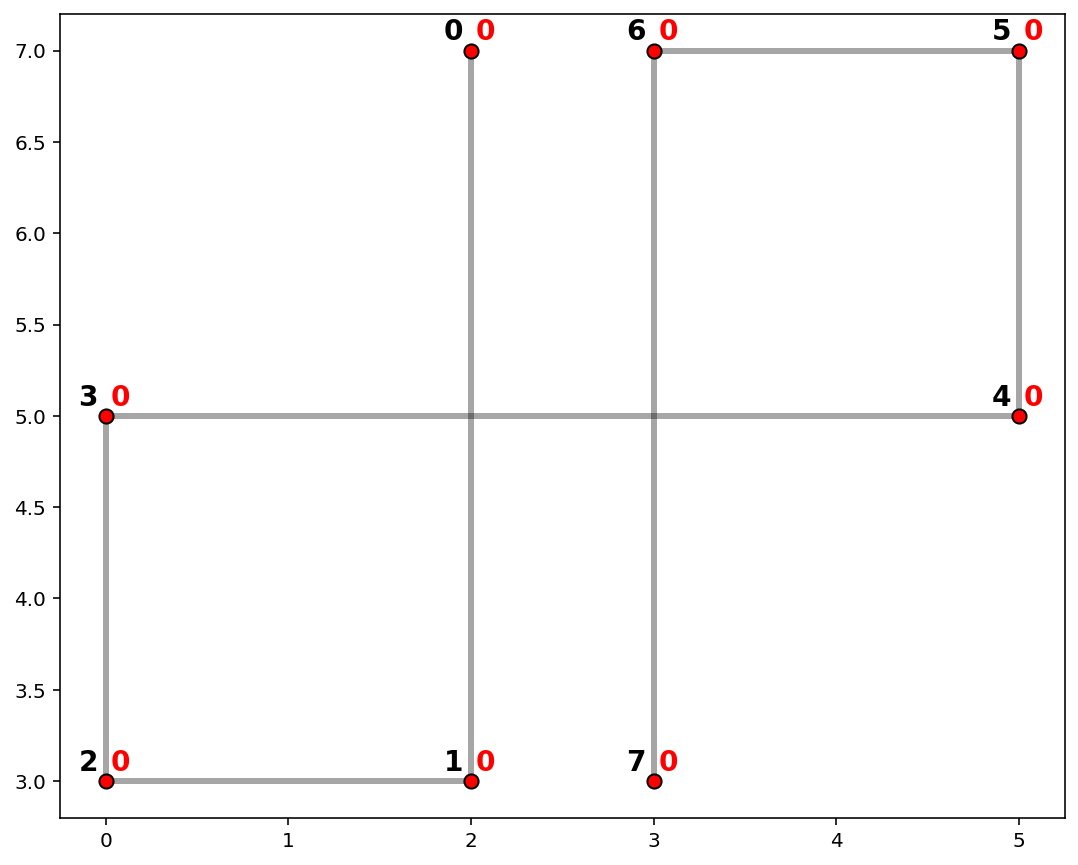

In [9]:
base = arcs_df.plot(lw=3, color="k", alpha=.35, figsize=(9, 9))
vertices_df.plot(ax=base, fc="r", ec="k", markersize=50, zorder=2)
# vertex labels
vert_labels(vertices_df, base, 14)
vert_labels(vertices_df, base, 14, offset=[-0.15, 0.025], col="id", c="k")

The plot above shows network arcs in gray with vertices in red. Also, vertices are labled in black and component membership is labeled in red. Since there are no actual intersections between segments ``(0,1),(3,4)`` or ``(3,4),(6,7)``, there are no vertices. Therefore, a shortest path from vertex ``0`` to ``7`` must follow the route ``{1,2,3,4,5,6}`` for a total of 21 units of distance.

In [10]:
ntw.full_distance_matrix(n_processes=1, gen_tree=True)

In [11]:
ntw.network_trees[0][7]

[6, 5, 4, 3, 2, 1, 0]

In [12]:
ntw.distance_matrix[0][7]

21.0

--------------------------

##### 1.b — Goalpost example
###### Create some line segments of ``libpysal.cg.Chain`` objects

In [13]:
U = [Chain([Point((2,2)), Point((2,1)), Point((4,1)), Point((4,2))])]
I = [Chain([Point((3,0)), Point((3,1))])]
arcs = U + I
arcs

###### Instantiate a ``spaghetti.Network`` object

In [14]:
ntw = spaghetti.Network(in_data=arcs)

/Users/the-gaboardi/miniconda3/envs/py39_spgh_dev/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: (4, 5).
  warnings.warn(message)
/Users/the-gaboardi/miniconda3/envs/py39_spgh_dev/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There are 2 islands with ids: (0, 3), (4, 5).
  warnings.warn(message)


###### Examine the components
There are two components.

In [15]:
ntw.network_n_components

2

Component ``0`` includes 4 vertices (the "goal") and component ``1`` includes 2 (the "post").

In [16]:
ntw.network_component_vertices

{0: [0, 1, 2, 3], 1: [4, 5]}

###### Extract the network vertices and arcs

In [17]:
vertices_df, arcs_df = spaghetti.element_as_gdf(ntw, vertices=True, arcs=True)
vertices_df

,id,geometry,comp_label
0,0,POINT (2.00000 2.00000),0
1,1,POINT (2.00000 1.00000),0
2,2,POINT (4.00000 1.00000),0
3,3,POINT (4.00000 2.00000),0
4,4,POINT (3.00000 0.00000),1
5,5,POINT (3.00000 1.00000),1


In [18]:
arcs_df

,id,geometry,comp_label
0,"(0, 1)","LINESTRING (2.00000 2.00000, 2.00000 1.00000)",0
1,"(1, 2)","LINESTRING (2.00000 1.00000, 4.00000 1.00000)",0
2,"(2, 3)","LINESTRING (4.00000 1.00000, 4.00000 2.00000)",0
3,"(4, 5)","LINESTRING (3.00000 0.00000, 3.00000 1.00000)",1


###### Plot

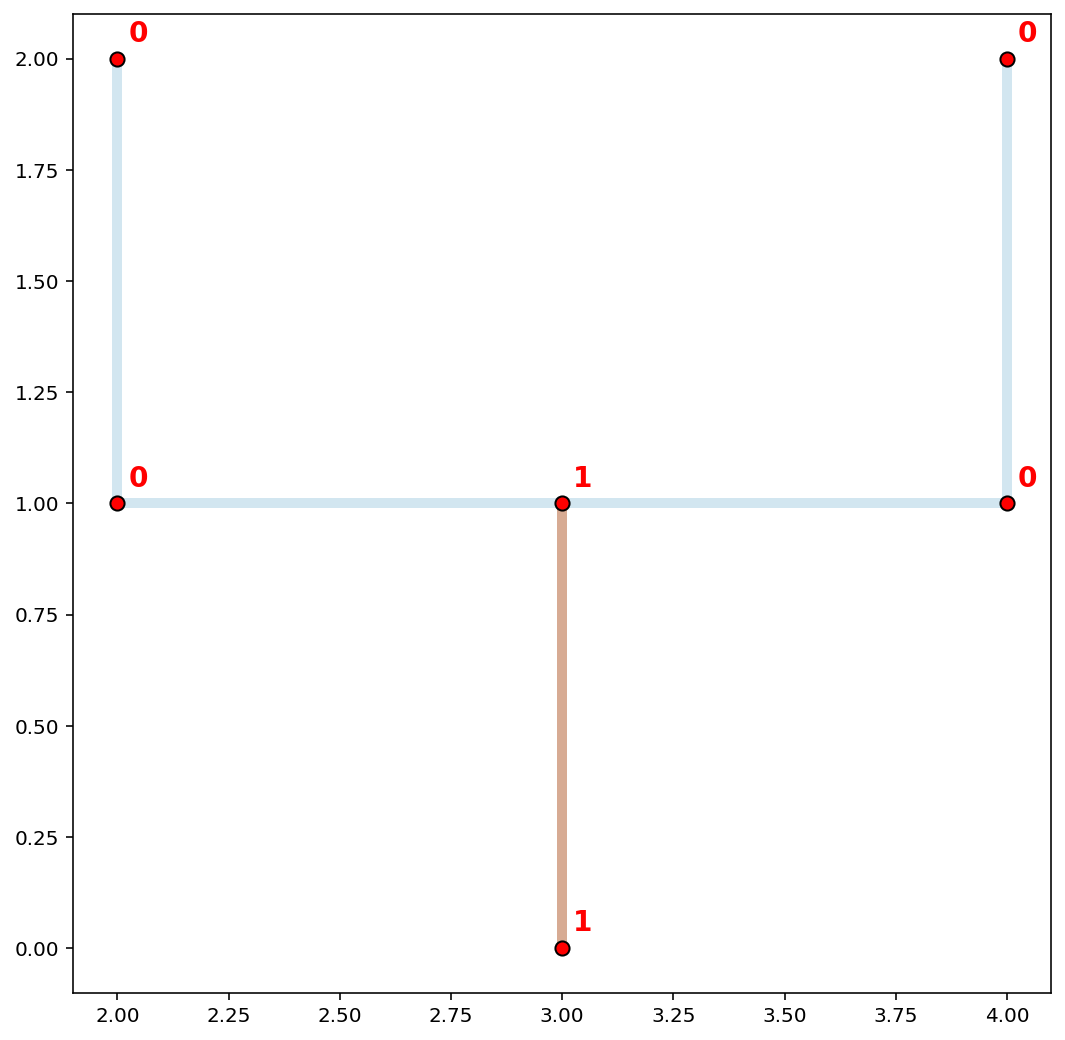

In [19]:
base_kws = {"alpha":.5, "lw":5, "cmap":"Paired", "column":"comp_label"}
base = arcs_df.plot(figsize=(9, 9), **base_kws)
vertices_df.plot(ax=base, fc="r", ec="k", markersize=50, zorder=2)
# vertex labels
vert_labels(vertices_df, base, 14)

As stated previously, flow from one network segment to another is only possible when segments share a vertex. In this case, no vertex is actually shared, although superficially there does appear to be. The plot above visualizes this concept by showing the two (dis)connected components of the "goalpost" network. Network arcs are colored by component membership and vertices are labeled by component membership. This is also demonstrated below when overlaying a plot of [libpysal.weights.W](https://pysal.org/libpysal/generated/libpysal.weights.W.html#libpysal.weights.W). This is accomplished below with arcs also shown with component membership (black nodes connected with black edges and labeled in black).

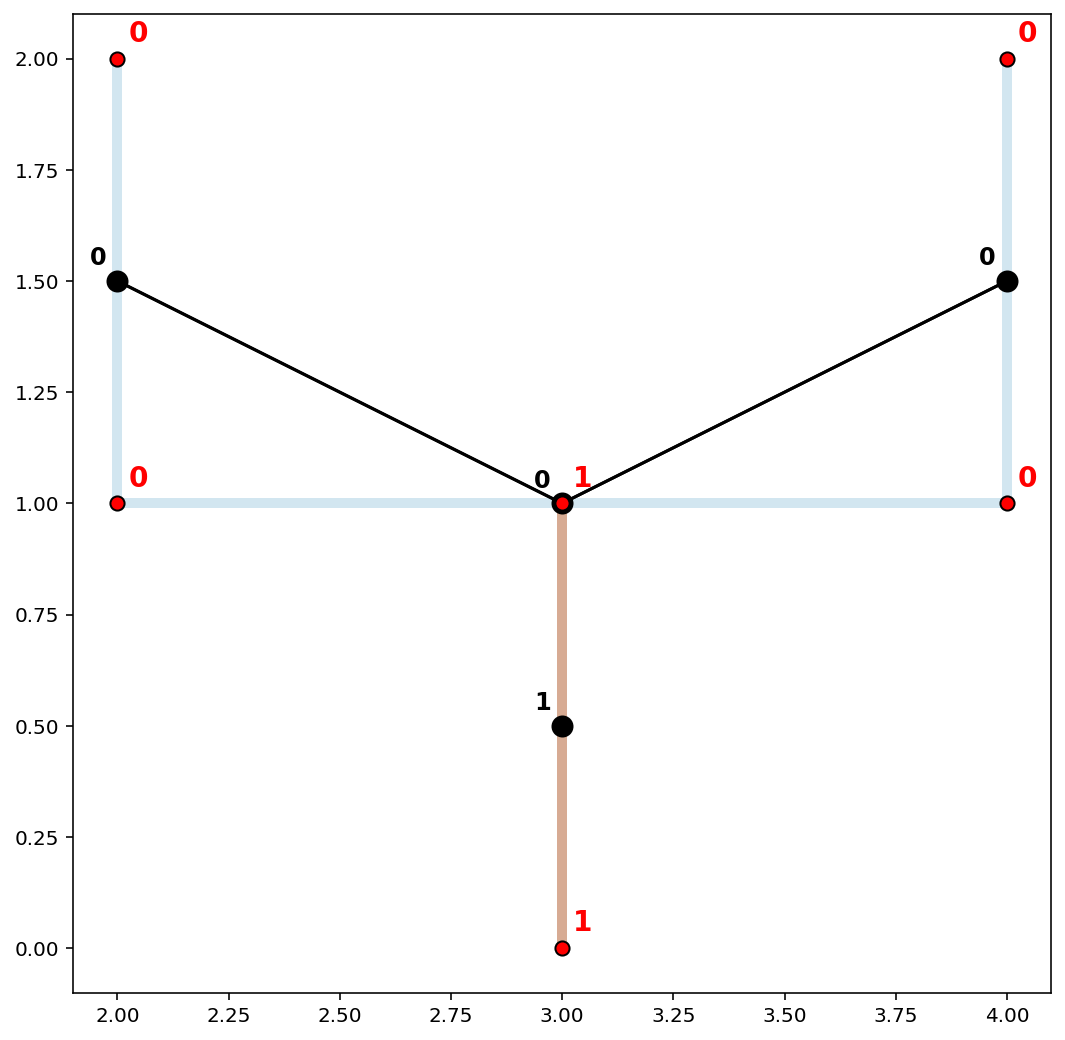

In [20]:
base_kws = {"alpha":.5, "lw":5, "cmap":"Paired", "column":"comp_label"}
base = arcs_df.plot(figsize=(9, 9), zorder=0, **base_kws)
# plot keywords
node_kws, edge_kws = {"s":100, "zorder":2}, {"zorder":1}
w_kws = {"edge_kws":edge_kws, "node_kws":node_kws}
ntw.w_network.plot(arcs_df, indexed_on="id", ax=base, **w_kws)
vertices_df.plot(ax=base, fc="r", ec="k", markersize=50, zorder=2)
# arc labels
arc_labels(arcs_df, base, 12)
# vertex labels
vert_labels(vertices_df, base, 14)

However, if the line segments were digitized "properly" a single connected component can be obtained (we emphasize "properly" because segments of a spatial network do not always intersect to form a single component in reality, for example highway over/underpases). In order to obtained a single connected component in this case we can simply add another point—``(3,1)``—to the initial collection of lines prior to network instantiation.

In [21]:
U = [Chain([Point((2,2)), Point((2,1)), Point((3,1)), Point((4,1)), Point((4,2))])]
I = [Chain([Point((3,0)), Point((3,1))])]
arcs = U + I
ntw = spaghetti.Network(in_data=arcs)
print("Network components:\t", ntw.network_n_components)
print("Network vertices:\t", ntw.network_component_vertices)
vertices_df, arcs_df = spaghetti.element_as_gdf(ntw, vertices=True, arcs=True)

Network components:	 1
Network vertices:	 {0: [0, 1, 2, 3, 4, 5]}


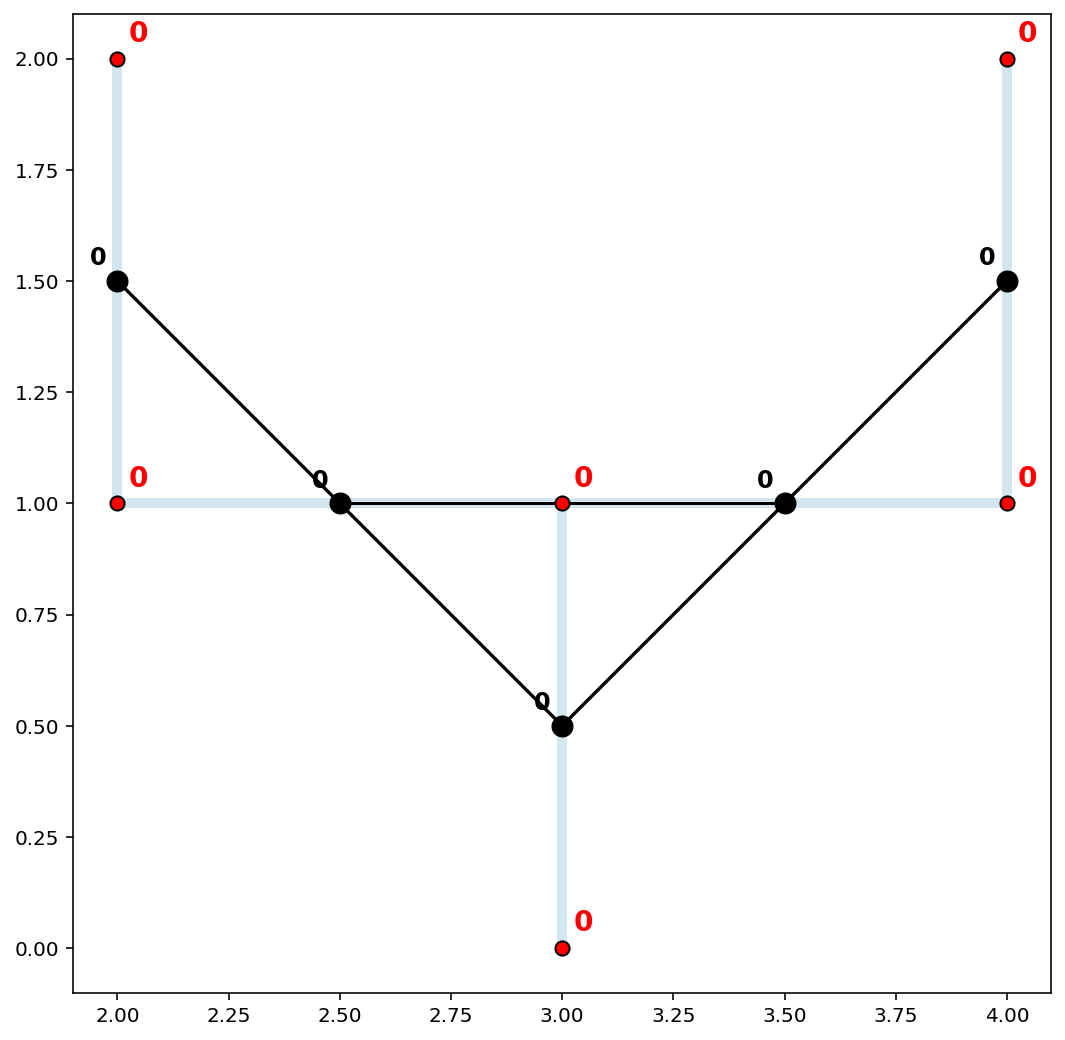

In [22]:
base_kws = {"alpha":.5, "lw":5, "cmap":"Paired", "column":"comp_label"}
base = arcs_df.plot(figsize=(9, 9), zorder=0, **base_kws)
# plot keywords
node_kws, edge_kws = {"s":100, "zorder":2}, {"zorder":1}
w_kws = {"edge_kws":edge_kws, "node_kws":node_kws}
ntw.w_network.plot(arcs_df, indexed_on="id", ax=base, **w_kws)
vertices_df.plot(ax=base, fc="r", ec="k", markersize=50, zorder=2)
# arc labels
arc_labels(arcs_df, base, 12)
# vertex labels
vert_labels(vertices_df, base, 14)

Now both the network vertices and spatially-weighted arcs are all members of a single connected component.

-------------------

##### 1.c — Empirical Example: [John Snow's Cholera Map](https://github.com/pysal/libpysal/tree/master/libpysal/examples/snow_maps)

In [23]:
libpysal.examples.explain("snow_maps")

snow_maps

Public water pumps and Cholera deaths in London 1854 (John Snow's Cholera Map)
-----------------------------------------------------------------

* SohoPeople.dbf: attribute data for Cholera deaths. (k=2)
* SohoPeople.prj: ESRI projection file.
* SohoPeople.sbn: spatial index.
* SohoPeople.sbx: spatial index.
* SohoPeople.shp: Point shapefile for Cholera deaths. (n=324)
* SohoPeople.shx: spatial index.
* SohoWater.dbf: attribute data for public water pumps. (k=1)
* SohoWater.prj: ESRI projection file.
* SohoWater.sbn: spatial index.
* SohoWater.sbx: spatial index.
* SohoWater.shp: Point shapefile for public water pumps. (n=13)
* SohoWater.shx: spatial index.
* Soho_Network.dbf: attribute data for street network. (k=1)
* Soho_Network.prj: ESRI projection file.
* Soho_Network.sbn: spatial index.
* Soho_Network.sbx: spatial index.
* Soho_Network.shp: Line shapefile for street network. (n=118)
* Soho_Network.shx: spatial index.

Original data: Snow, J. (1849). On the Mode of Com

In [24]:
soho = geopandas.read_file(libpysal.examples.get_path("Soho_Network.shp"))
soho = soho.to_crs(epsg=32630)
soho

,Id,geometry
0,0,"LINESTRING (698394.862 5710772.742, 698230.823..."
1,0,"LINESTRING (698373.590 5710607.200, 698481.244..."
2,0,"LINESTRING (698466.845 5710652.970, 698381.993..."
3,0,"LINESTRING (698373.590 5710607.200, 698322.058..."
4,0,"LINESTRING (698322.058 5710573.561, 698304.893..."
...,...,...
113,0,"LINESTRING (698851.874 5710691.953, 698837.518..."
114,0,"LINESTRING (698860.680 5710803.234, 698825.980..."
115,0,"LINESTRING (698748.567 5710903.073, 698703.656..."
116,0,"LINESTRING (698715.115 5710881.223, 698695.567..."


In [25]:
ntw = spaghetti.Network(in_data=soho)

/Users/the-gaboardi/miniconda3/envs/py39_spgh_dev/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 45 disconnected components.
 There are 24 islands with ids: (22, 23), (28, 29), (30, 31), (47, 48), (49, 50), (58, 59), (67, 68), (75, 76), (84, 85), (86, 87), (108, 109), (110, 111), (121, 122), (128, 129), (172, 173), (183, 184), (185, 186), (190, 191), (208, 209), (212, 213), (216, 217), (218, 219), (220, 221), (222, 223).
  warnings.warn(message)
/Users/the-gaboardi/miniconda3/envs/py39_spgh_dev/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 45 disconnected components.
 There are 37 islands with ids: (5, 149), (22, 23), (24, 27), (28, 29), (30, 31), (47, 48), (49, 50), (58, 59), (67, 68), (72, 74), (75, 76), (84, 85), (86, 87), (89, 90), (108, 109), (110, 111), (121, 122), (124, 127), (128, 129), (150, 152), (153, 155), (163,

In [26]:
ntw.network_n_components

45

<AxesSubplot:>

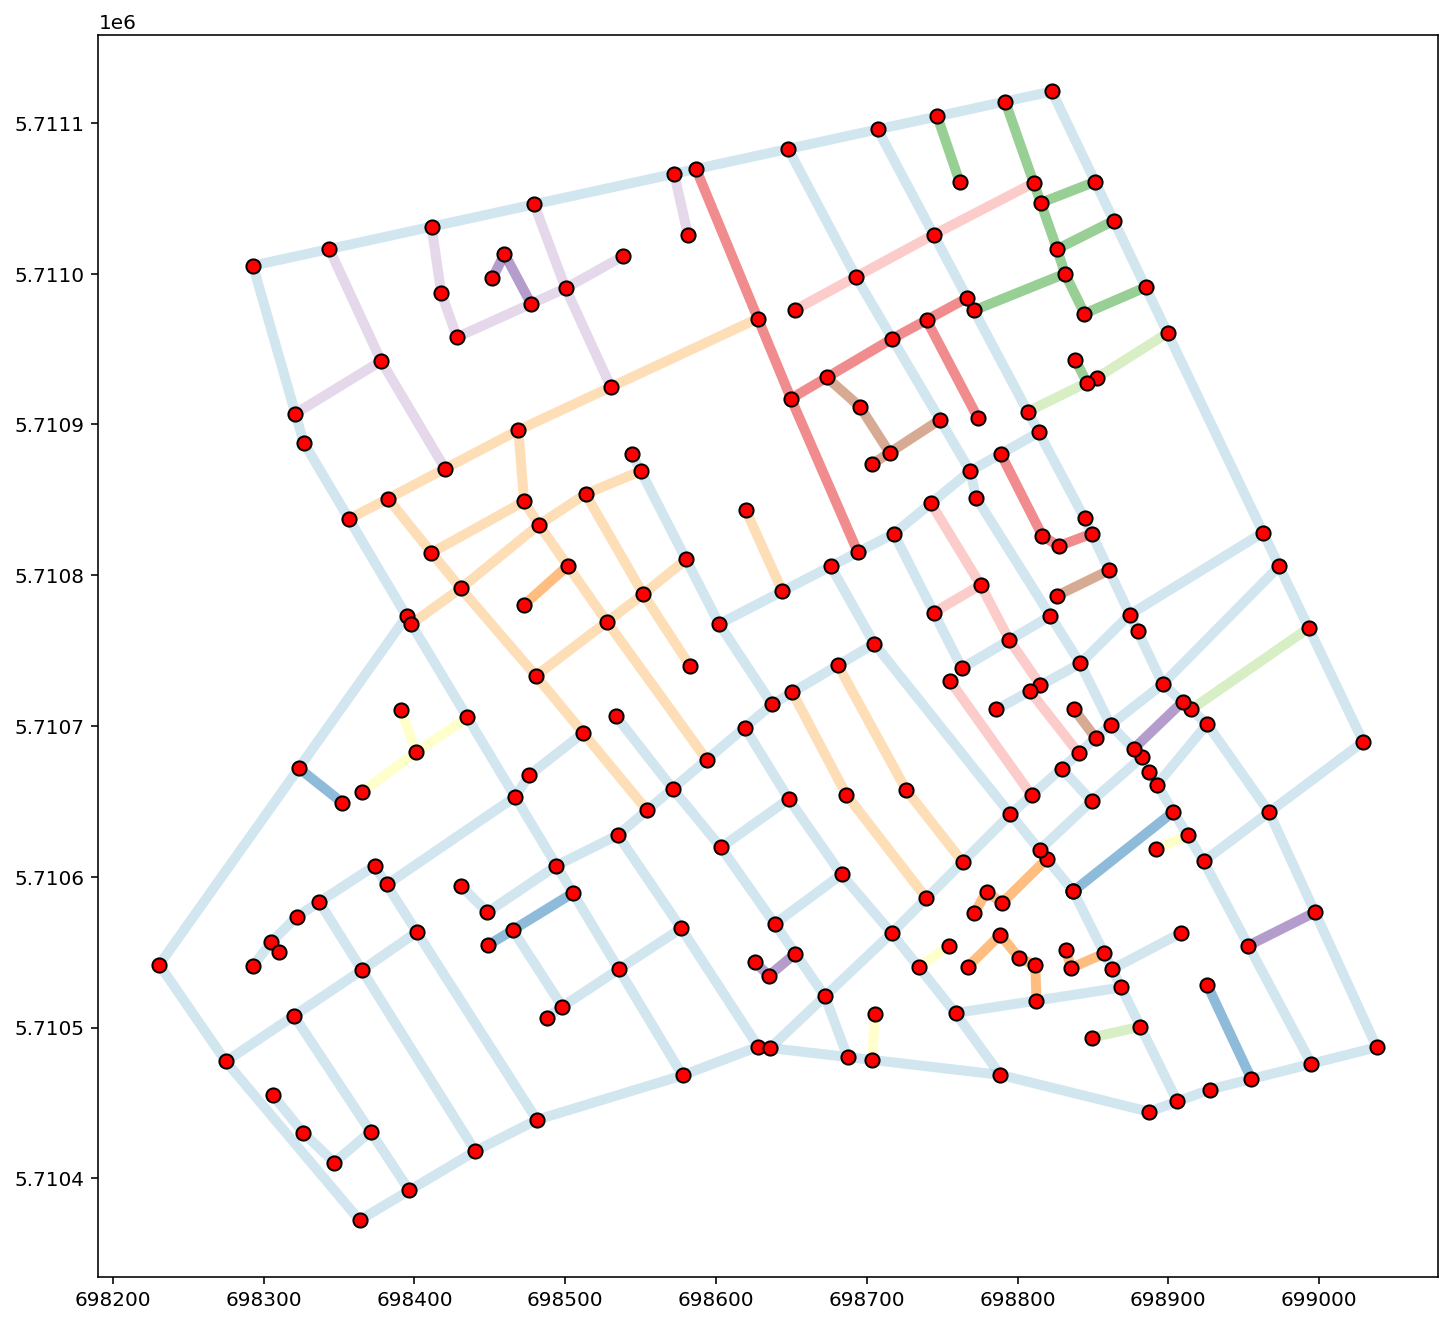

In [27]:
vertices_df, arcs_df = spaghetti.element_as_gdf(ntw, vertices=True, arcs=True)
base_kws = {"alpha":.5, "lw":5, "cmap":"Paired", "column":"comp_label"}
base = arcs_df.plot(figsize=(12, 12), **base_kws)
vertices_df.plot(ax=base, fc="r", ec="k", markersize=50, zorder=2)

In this dataset that are ***45*** components of the networks, indicating some serious issues with intended connectivity. When overlayed with arc spatial weights it becomes clear that many of the arcs that appear to (and should) intersect, actually do not.

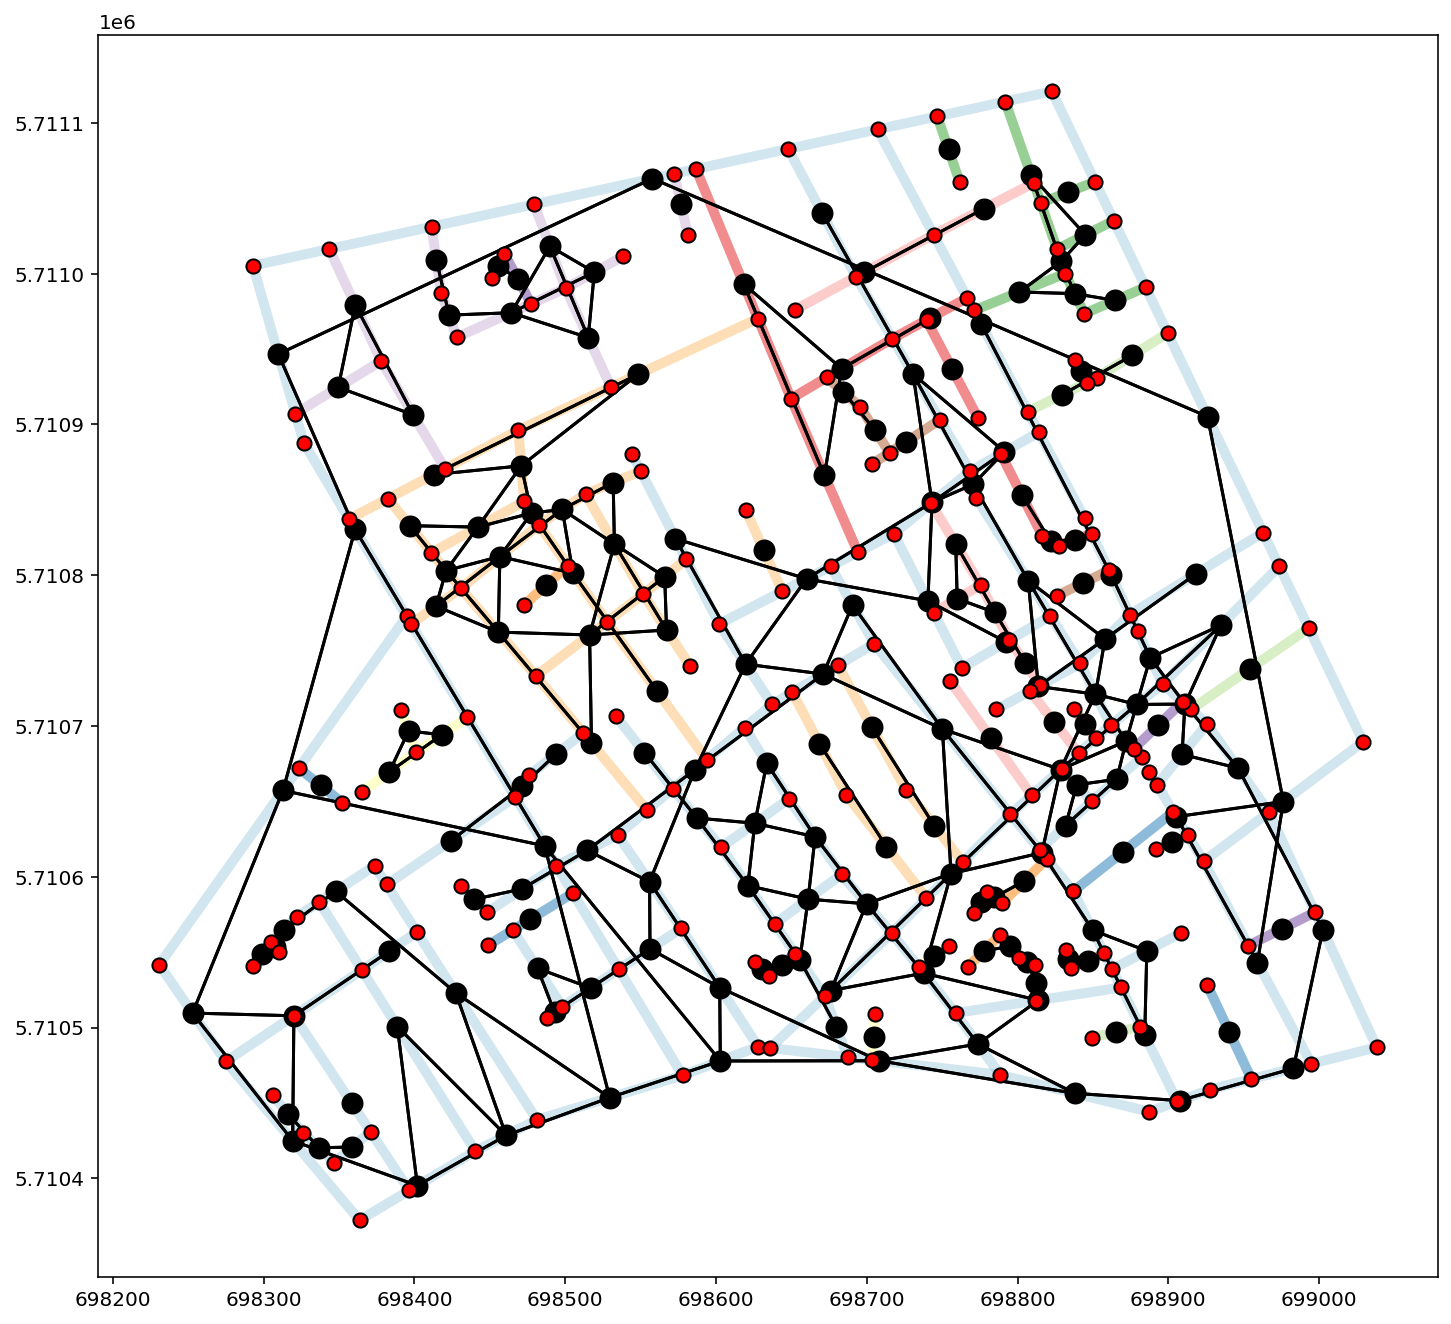

In [28]:
base_kws = {"alpha":.5, "lw":5, "cmap":"Paired", "column":"comp_label"}
base = arcs_df.plot(figsize=(12, 12), zorder=0, **base_kws)
# plot keywords
node_kws, edge_kws = {"s":100, "zorder":2}, {"zorder":1}
w_kws = {"edge_kws":edge_kws, "node_kws":node_kws}
ntw.w_network.plot(arcs_df, indexed_on="id", ax=base, **w_kws)
vertices_df.plot(ax=base, fc="r", ec="k", markersize=50, zorder=2);

Fuzzy contiguity can be acheived through [libpysal.weights.fuzzy_contiguity()](https://pysal.org/libpysal/generated/libpysal.weights.fuzzy_contiguity.html#libpysal.weights.fuzzy_contiguity), which provides us with a single connected component, but does not capture the true nature of the network stucture, as demonstrated below.

In [29]:
fuzzy = libpysal.weights.fuzzy_contiguity(arcs_df)
fuzzy.remap_ids(arcs_df.id)
fuzzy.n_components

/Users/the-gaboardi/miniconda3/envs/py39_spgh_dev/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 19 disconnected components.
 There are 11 islands with ids: 30, 31, 60, 73, 81, 111, 156, 166, 181, 183, 185.
  warnings.warn(message)


19

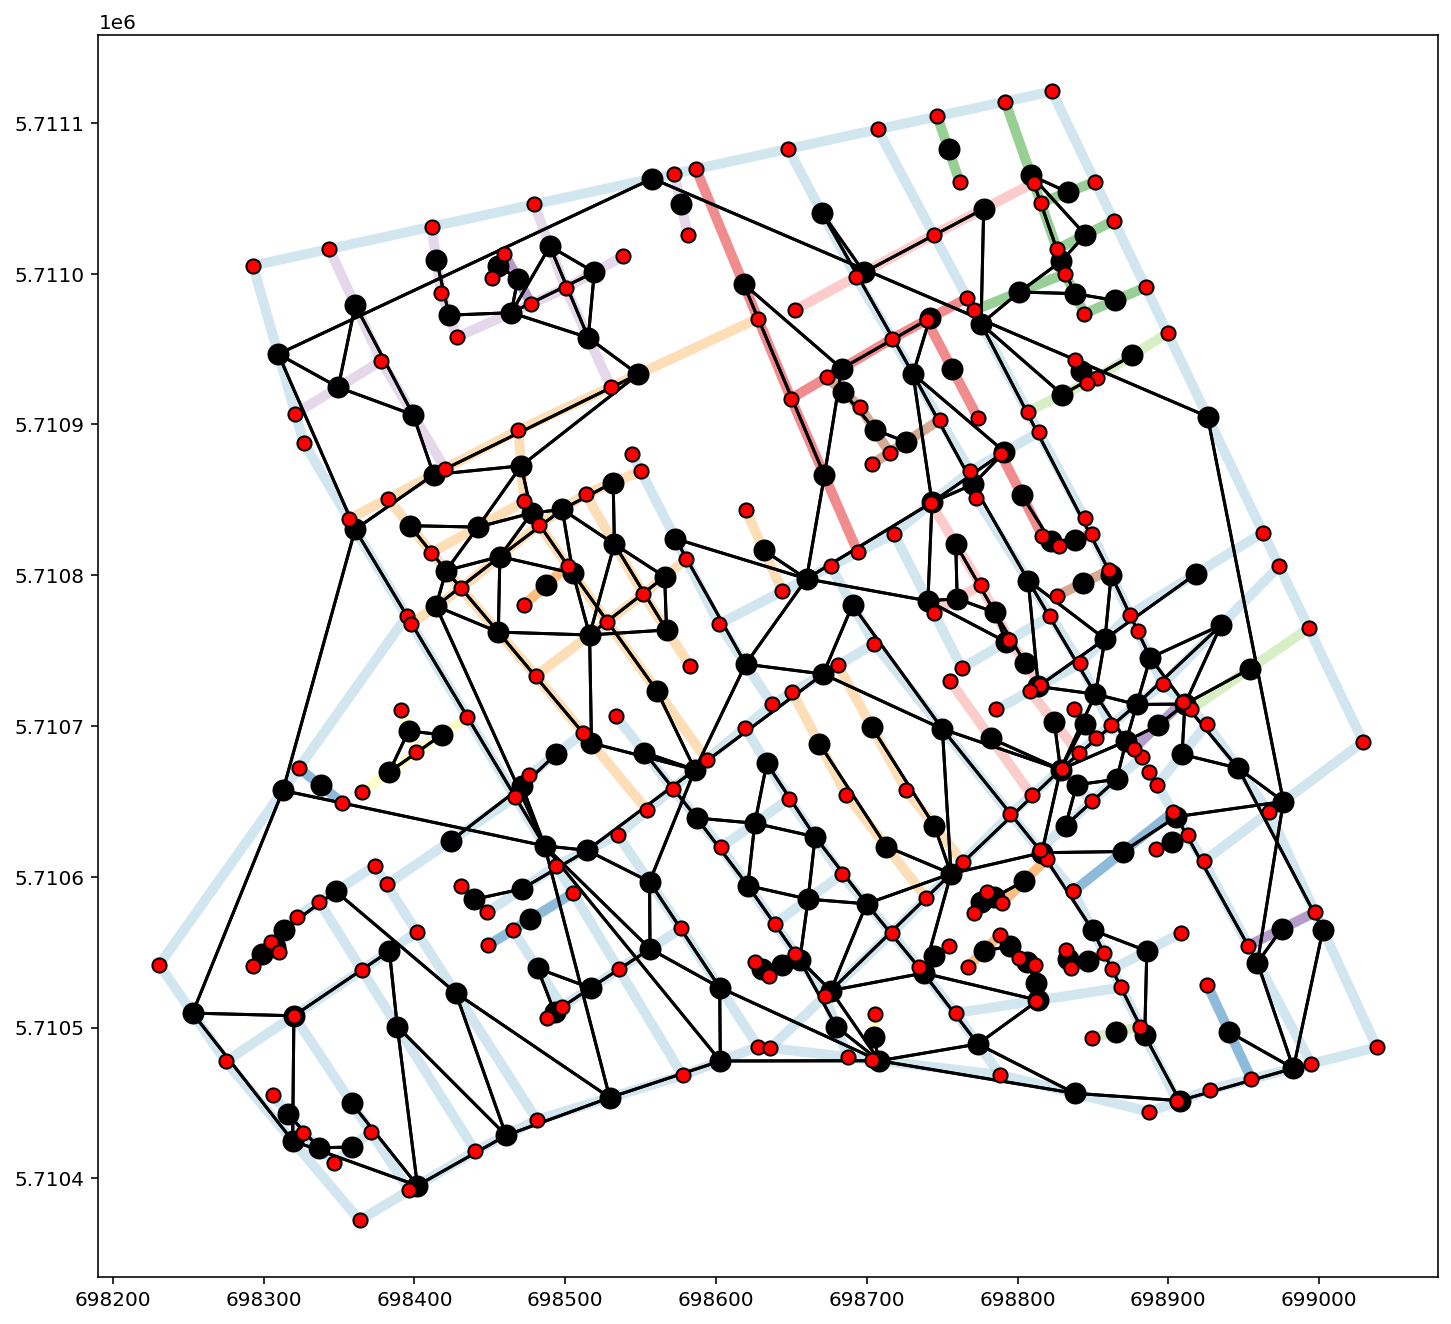

In [30]:
base_kws = {"alpha":.5, "lw":5, "cmap":"Paired", "column":"comp_label"}
base = arcs_df.plot(figsize=(12, 12), zorder=0, **base_kws)
# plot keywords
node_kws, edge_kws = {"s":100, "zorder":2}, {"zorder":1}
w_kws = {"edge_kws":edge_kws, "node_kws":node_kws}
fuzzy.plot(arcs_df, indexed_on="id", ax=base, **w_kws)
vertices_df.plot(ax=base, fc="r", ec="k", markersize=50, zorder=2);

The issue with the [Soho_Network.shp](https://github.com/pysal/libpysal/tree/master/libpysal/examples/snow_maps) dataset is not precision, it is that not all true intersections are demarcated with vertices, as in the "goalpost" example above. This is clearly seen in the upper two segments of the network exterior where each segment is a single object, not broken at joining segments. In order to properly use the ``Soho_Network.shp`` dataset as a network, geometric preprocessing would need to be performed in order to extract all intersections.

-----------------------
### 2. Precision limitations and/or known issues with digitization
##### Revisting the "goalpost" network — Slightly imprecise coordinates
Here the "I" of the goalpost has been digitized slightly short of the intersection with the "U" component.

In [31]:
U = [Chain([Point((2,2)), Point((2,1)), Point((3,1)), Point((4,1)), Point((4,2))])]
I = [Chain([Point((3,0)), Point((3,0.99999))])]
arcs = U + I
ntw = spaghetti.Network(in_data=arcs)
print("Network components:\t", ntw.network_n_components)
print("Network vertices:\t", ntw.network_component_vertices)
vertices_df, arcs_df = spaghetti.element_as_gdf(ntw, vertices=True, arcs=True)

Network components:	 2
Network vertices:	 {0: [0, 1, 2, 3, 4], 1: [5, 6]}


/Users/the-gaboardi/miniconda3/envs/py39_spgh_dev/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: (5, 6).
  warnings.warn(message)
/Users/the-gaboardi/miniconda3/envs/py39_spgh_dev/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There are 2 islands with ids: (0, 4), (5, 6).
  warnings.warn(message)


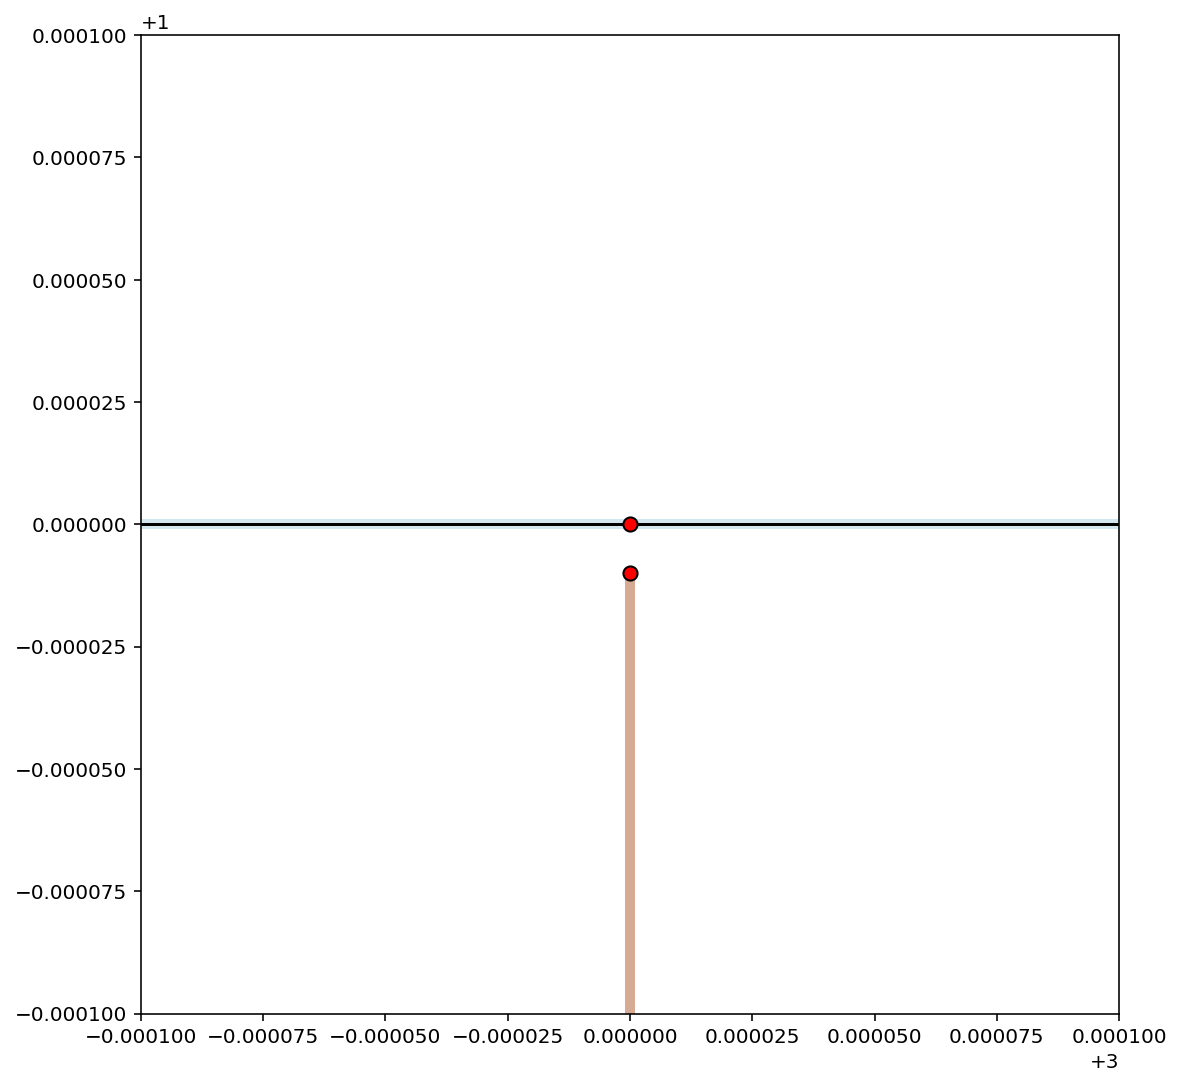

In [32]:
base_kws = {"alpha":.5, "lw":5, "cmap":"Paired", "column":"comp_label"}
base = arcs_df.plot(figsize=(9, 9), zorder=0, **base_kws)
# plot keywords
node_kws, edge_kws = {"s":100, "zorder":2}, {"zorder":1}
w_kws = {"edge_kws":edge_kws, "node_kws":node_kws}
ntw.w_network.plot(arcs_df, indexed_on="id", ax=base, **w_kws)
vertices_df.plot(ax=base, fc="r", ec="k", markersize=50, zorder=2)
plt.xlim(2.9999, 3.0001)
plt.ylim(0.9999, 1.0001);

A small gap is shown in the plot above resulting in two network components.

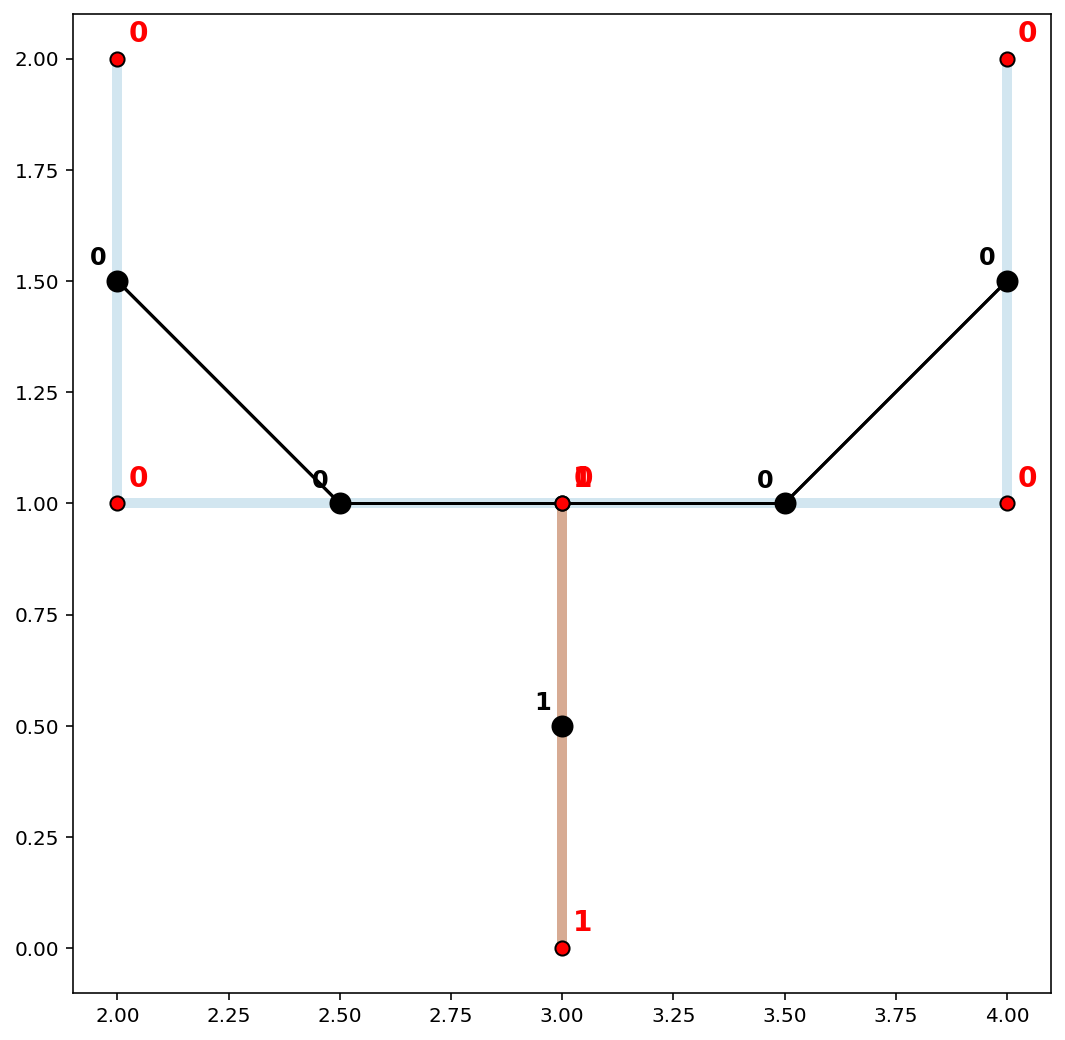

In [33]:
base_kws = {"alpha":.5, "lw":5, "cmap":"Paired", "column":"comp_label"}
base = arcs_df.plot(figsize=(9, 9), zorder=0, **base_kws)
# plot keywords
node_kws, edge_kws = {"s":100, "zorder":2}, {"zorder":1}
w_kws = {"edge_kws":edge_kws, "node_kws":node_kws}
ntw.w_network.plot(arcs_df, indexed_on="id", ax=base, **w_kws)
vertices_df.plot(ax=base, fc="r", ec="k", markersize=50, zorder=2)
# arc labels
arc_labels(arcs_df, base, 12)
# vertex labels
vert_labels(vertices_df, base, 14)

In order to accomodate situations like these where network elements are digitized in generally the correct locations but the precision is lacking, the ``vertex_atol`` parameter can be invoked when instantiating the network. This parameter allows for the rounding of decimal places (not significant digits — see [vertex_sig](https://pysal.org/spaghetti/generated/spaghetti.Network.html#spaghetti.Network)), but should be used with caution.

In [34]:
ntw = spaghetti.Network(in_data=arcs, vertex_atol=3)
print("Network components:\t", ntw.network_n_components)
print("Network vertices:\t", ntw.network_component_vertices)
vertices_df, arcs_df = spaghetti.element_as_gdf(ntw, vertices=True, arcs=True)

Network components:	 1
Network vertices:	 {0: [0, 1, 2, 3, 4, 5]}


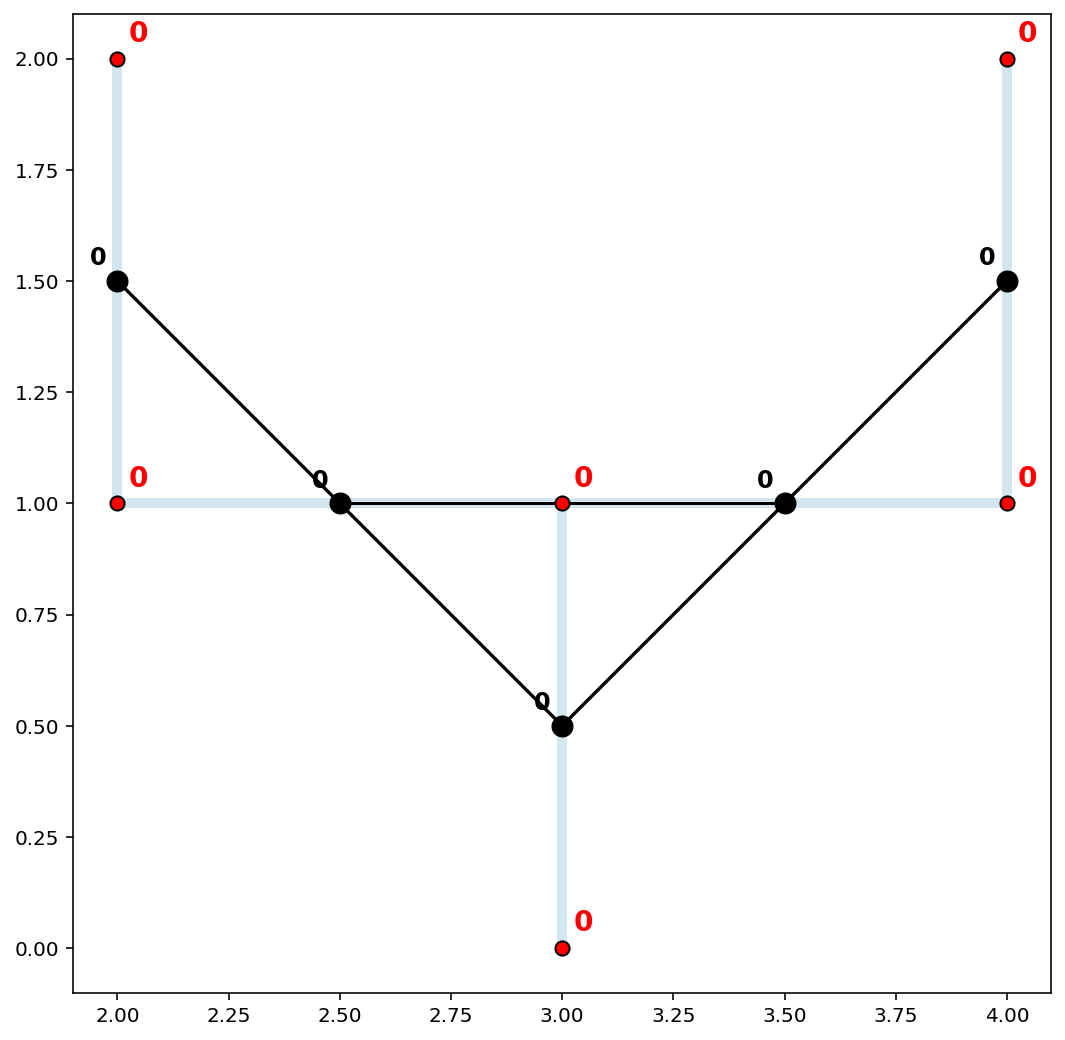

In [35]:
base_kws = {"alpha":.5, "lw":5, "cmap":"Paired", "column":"comp_label"}
base = arcs_df.plot(figsize=(9, 9), zorder=0, **base_kws)
# plot keywords
node_kws, edge_kws = {"s":100, "zorder":2}, {"zorder":1}
w_kws = {"edge_kws":edge_kws, "node_kws":node_kws}
ntw.w_network.plot(arcs_df, indexed_on="id", ax=base, **w_kws)
vertices_df.plot(ax=base, fc="r", ec="k", markersize=50, zorder=2)
# arc labels
arc_labels(arcs_df, base, 12)
# vertex labels
vert_labels(vertices_df, base, 14)

-----------------------
### 3. Distance matrices and shortest paths for multiple connected components
##### Continuing with the original "goalpost" network comprised of 2 components

In [36]:
U = [Chain([Point((2,2)), Point((2,1)), Point((4,1)), Point((4,2))])]
I = [Chain([Point((3,0)), Point((3,1))])]
arcs = U + I
ntw = spaghetti.Network(in_data=arcs)
ntw.full_distance_matrix(n_processes=1, gen_tree=True)

/Users/the-gaboardi/miniconda3/envs/py39_spgh_dev/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: (4, 5).
  warnings.warn(message)
/Users/the-gaboardi/miniconda3/envs/py39_spgh_dev/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There are 2 islands with ids: (0, 3), (4, 5).
  warnings.warn(message)


In [37]:
ntw.network_component_vertices

{0: [0, 1, 2, 3], 1: [4, 5]}

In [38]:
ntw.distance_matrix

array([[ 0.,  1.,  3.,  4., inf, inf],
       [ 1.,  0.,  2.,  3., inf, inf],
       [ 3.,  2.,  0.,  1., inf, inf],
       [ 4.,  3.,  1.,  0., inf, inf],
       [inf, inf, inf, inf,  0.,  1.],
       [inf, inf, inf, inf,  1.,  0.]])

From vertex ``0`` only vertices ``{1,2,3}`` can be reached. This is shown in the distance matrix by ``inf`` values in the 4th and 5th columns, and by identical origin-destination shortest paths in the network trees.

In [39]:
ntw.distance_matrix[0]

array([ 0.,  1.,  3.,  4., inf, inf])

In [40]:
ntw.network_trees[0]

{0: [0], 1: [0], 2: [1, 0], 3: [2, 1, 0], 4: [4], 5: [5]}

Like the example in ``cell 21`` above, by inserting a vertex complete network connectivity can be achieved.

In [41]:
U = [Chain([Point((2,2)), Point((2,1)), Point((3,1)), Point((4,1)), Point((4,2))])]
I = [Chain([Point((3,0)), Point((3,1))])]
arcs = U + I
ntw = spaghetti.Network(in_data=arcs)
ntw.full_distance_matrix(n_processes=1, gen_tree=True)

In [42]:
ntw.network_component_vertices

{0: [0, 1, 2, 3, 4, 5]}

In [43]:
ntw.distance_matrix

array([[0., 1., 2., 3., 4., 3.],
       [1., 0., 1., 2., 3., 2.],
       [2., 1., 0., 1., 2., 1.],
       [3., 2., 1., 0., 1., 2.],
       [4., 3., 2., 1., 0., 3.],
       [3., 2., 1., 2., 3., 0.]])

In [44]:
ntw.distance_matrix[0]

array([0., 1., 2., 3., 4., 3.])

In [45]:
ntw.network_trees[0]

{0: [0], 1: [0], 2: [1, 0], 3: [2, 1, 0], 4: [3, 2, 1, 0], 5: [2, 1, 0]}

-----------------------

### 4. Understanding network generation

##### Why does the `spaghetti.Network` object have so many vertices?

The core procedure for generating network representations is performed within the internal `spaghetti.Network._extractnetwork()` method. Here it is important to note that a `spaghetti.Network` instance is built up from the individual, constituent euclidean units of each line segment object. Therefore, the resulting network structure will generally have:
1. More vertices and links than may expected, and;
2. Many degree-2 vertices, which differs from a truly graph-theoretic object.

This is demonstrated below with a sinuous line.

In [46]:
def sine_chain(npts):
    """Create a sine line."""
    xs = numpy.linspace(1, 10, npts)
    xys = zip(xs, numpy.sin(xs))
    pts = [Point((x, y)) for (x, y) in xys]
    chain = Chain(pts)
    return chain

def sine_linestring_gdf(in_df, drop_col="id", dissolve_by="comp_label"):
    """Merge all line segments into a single line segment."""
    out_df = in_df.copy()
    out_df = out_df.dissolve(by=dissolve_by)
    out_df.reset_index(drop=True, inplace=True)
    out_df.drop(columns=drop_col, inplace=True)
    return out_df

Create a sine line

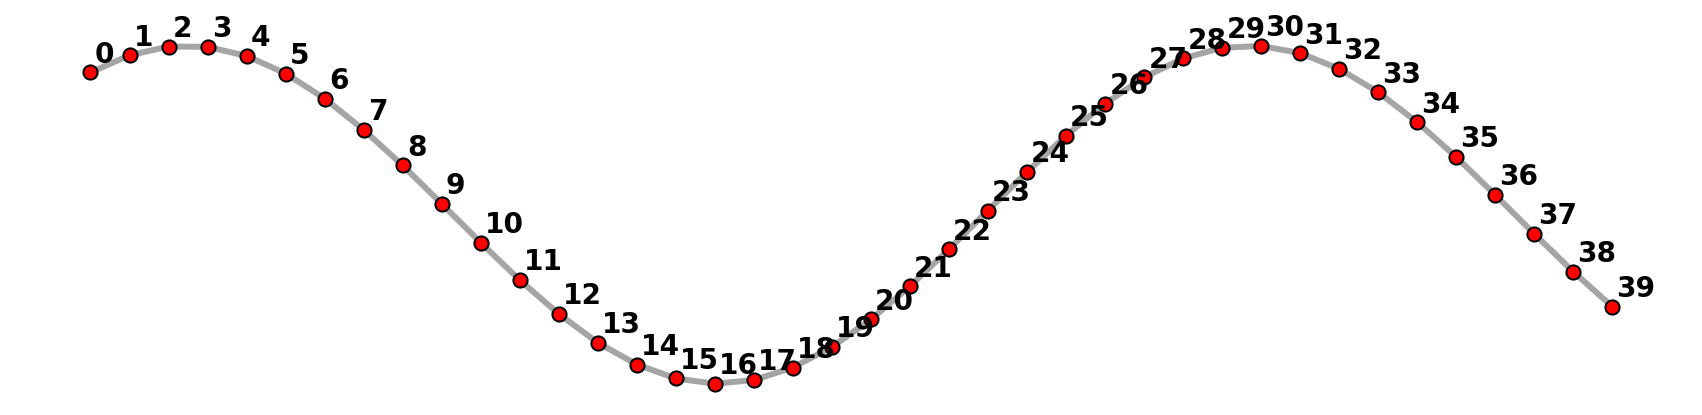

In [47]:
sine_points = 40
ntw = spaghetti.Network(in_data=sine_chain(sine_points))
vertices_df, arcs_df = spaghetti.element_as_gdf(ntw, vertices=True, arcs=True)
base = arcs_df.plot(lw=3, color="k", alpha=.35, figsize=(15, 5))
vertices_df.plot(ax=base, fc="r", ec="k", markersize=50, zorder=2)
# vertex labels
vert_labels(vertices_df, base, 14, col="id", c="k")
plt.axis("off");

Here we can see there are 40 vertices and 39 links in the network structure, not a single link with two endpoint vertices.

In [48]:
arcs_df.head()

,id,geometry,comp_label
0,"(0, 1)","LINESTRING (1.00000 0.84147, 1.23077 0.94275)",0
1,"(1, 2)","LINESTRING (1.23077 0.94275, 1.46154 0.99404)",0
2,"(2, 3)","LINESTRING (1.46154 0.99404, 1.69231 0.99263)",0
3,"(3, 4)","LINESTRING (1.69231 0.99263, 1.92308 0.93859)",0
4,"(4, 5)","LINESTRING (1.92308 0.93859, 2.15385 0.83479)",0


In [49]:
arcs_df.tail()

,id,geometry,comp_label
34,"(34, 35)","LINESTRING (8.84615 0.54687, 9.07692 0.34088)",0
35,"(35, 36)","LINESTRING (9.07692 0.34088, 9.30769 0.11682)",0
36,"(36, 37)","LINESTRING (9.30769 0.11682, 9.53846 -0.11344)",0
37,"(37, 38)","LINESTRING (9.53846 -0.11344, 9.76923 -0.33768)",0
38,"(38, 39)","LINESTRING (9.76923 -0.33768, 10.00000 -0.54402)",0


However, the set of network links can be dissolved into a single linestring with two endpoints.

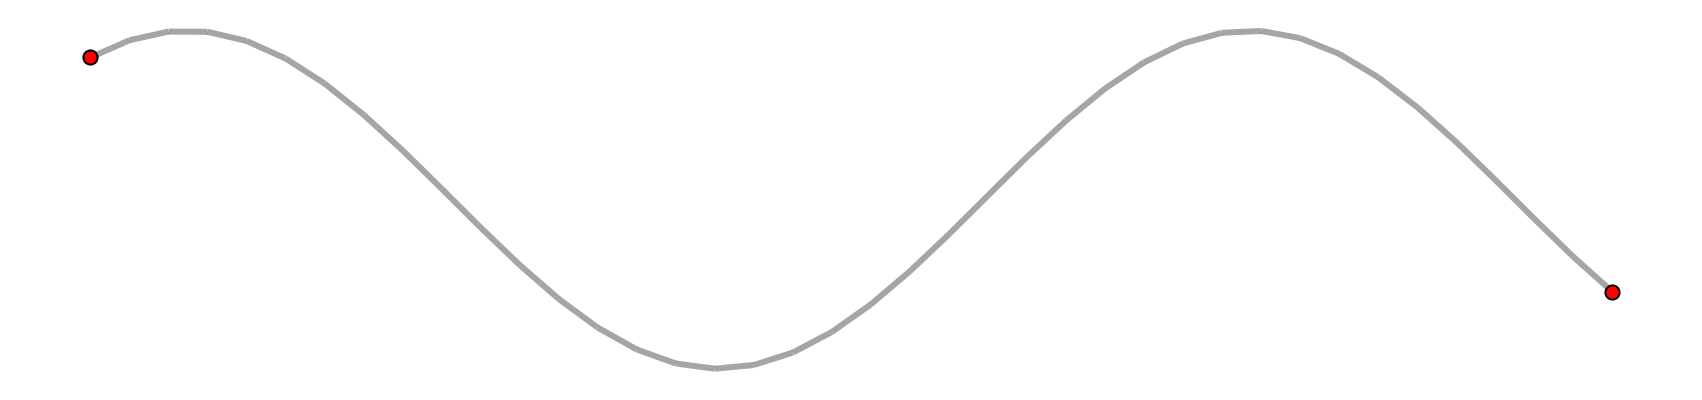

In [50]:
sine_df = sine_linestring_gdf(arcs_df)
sine_endpoints = sine_df.geometry.squeeze().boundary
sine_verts = geopandas.GeoDataFrame(geometry=[sine_endpoints])
base = sine_df.plot(lw=3, color="k", alpha=.35, figsize=(15, 5))
sine_verts.plot(ax=base, fc="r", ec="k", markersize=50, zorder=2)
plt.axis("off");

But if the singular sine line is used to instantiate a new network it is broken out again.

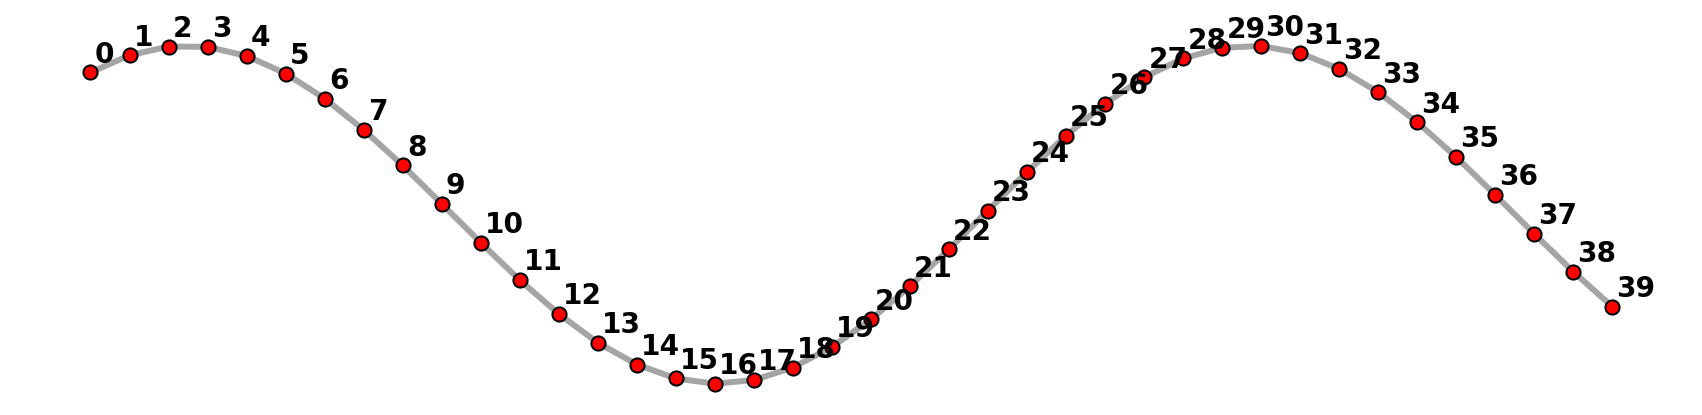

In [51]:
ntw = spaghetti.Network(in_data=sine_df)
vertices_df, arcs_df = spaghetti.element_as_gdf(ntw, vertices=True, arcs=True)
base = arcs_df.plot(lw=3, color="k", alpha=.35, figsize=(15, 5))
vertices_df.plot(ax=base, fc="r", ec="k", markersize=50, zorder=2)
# vertex labels
vert_labels(vertices_df, base, 14, col="id", c="k")
plt.axis("off");

Below this process is demonstrated with increasingly less granulated lines.

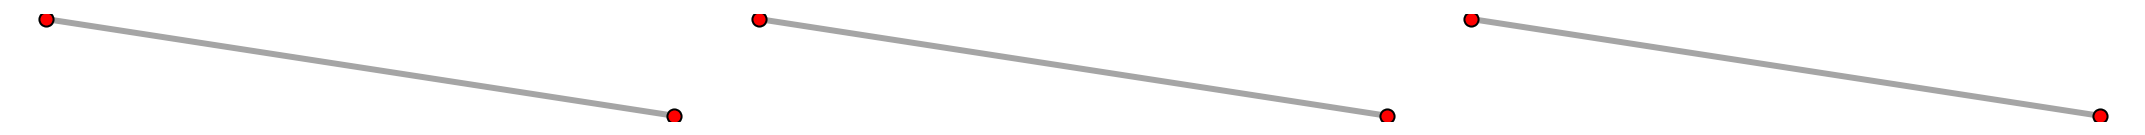

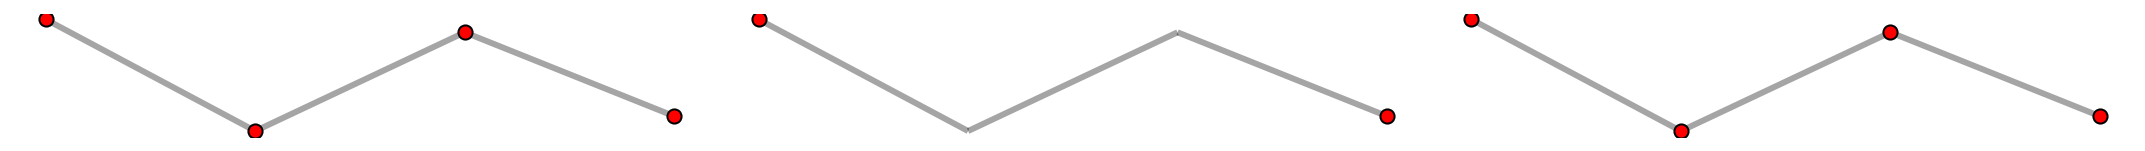

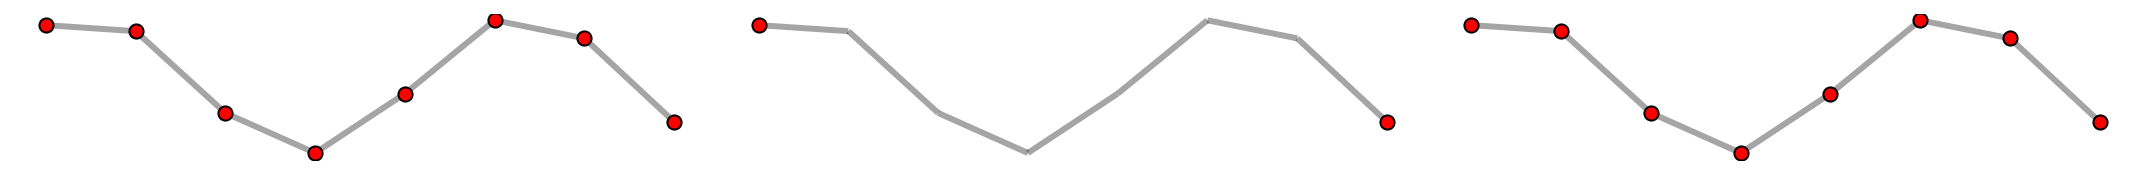

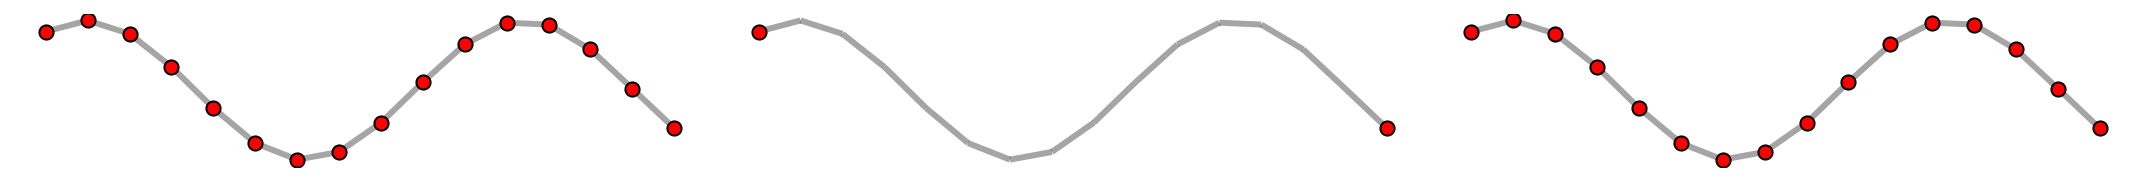

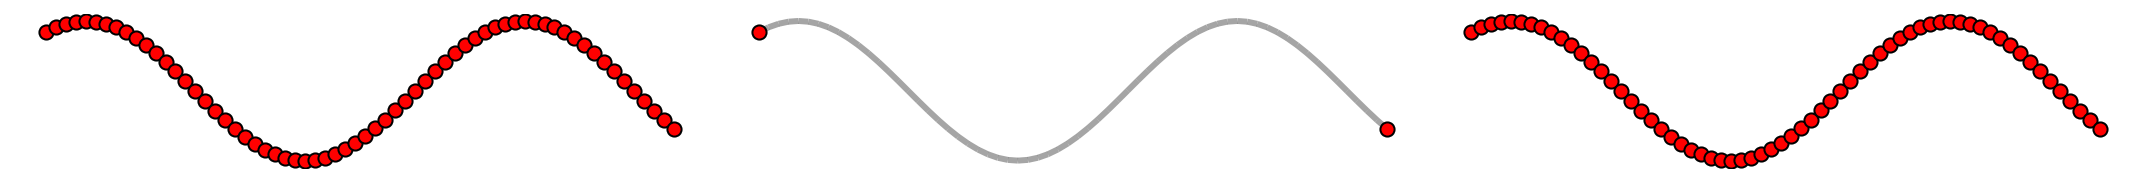

In [52]:
for sine_points in [2, 4, 4*2, 4**2, 4**3]:
    fig, axarr = plt.subplots(1,3, figsize=(15, 15))
    
    # raw sine network and vertices
    ntw = spaghetti.Network(in_data=sine_chain(sine_points))
    vertices_df, arcs_df = spaghetti.element_as_gdf(ntw, vertices=True, arcs=True)
    arcs_df.plot(ax=axarr[0], lw=3, color="k", alpha=.35, )
    vertices_df.plot(ax=axarr[0], fc="r", ec="k", markersize=50, zorder=2)
    axarr[0].axis("off")
    
    # sine line and vertices
    sine_df = sine_linestring_gdf(arcs_df)
    sine_endpoints = sine_df.geometry.squeeze().boundary
    sine_verts = geopandas.GeoDataFrame(geometry=[sine_endpoints])
    sine_df.plot(ax=axarr[1], lw=3, color="k", alpha=.35)
    sine_verts.plot(ax=axarr[1], fc="r", ec="k", markersize=50, zorder=2)
    axarr[1].axis("off")
    
    # sine line converted to network and vertices
    ntw = spaghetti.Network(in_data=sine_df)
    vertices_df, arcs_df = spaghetti.element_as_gdf(ntw, vertices=True, arcs=True)
    arcs_df.plot(ax=axarr[2], lw=3, color="k", alpha=.35, figsize=(15, 5))
    vertices_df.plot(ax=axarr[2], fc="r", ec="k", markersize=50, zorder=2)
    vert_labels(vertices_df, base, 14, col="id", c="k")
    axarr[2].axis("off")
    
    fig.tight_layout()

-----------------------